## Importes

Realizamos los importes necesarios para nuestro modelo

In [83]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
import pickle

from ast import literal_eval
#La lista tokens en la columna tokens es en realidad una representación de una lista hecha con un string, literal_eval lo transforma en una lista real

from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_predict
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint
from sklearn.feature_extraction.text import CountVectorizer
import xgboost as xgb

In [84]:
partes_train = []
cant_partes = 2
for i in range(cant_partes):
  parte = pd.read_csv(f'https://raw.githubusercontent.com/agomezalejo/7506R-1C2023-GRUPO22/main/train_tp2/train_data_procesado_FILTRADO_FINAL_parte_{i}.csv')
  partes_train.append(parte)
train_data = pd.concat(partes_train, ignore_index=True)

test_url = "https://raw.githubusercontent.com/agomezalejo/7506R-1C2023-GRUPO22/main/train_tp2/test_data_procesado_FILTRADO_FINAL.csv"
test_data = pd.read_csv(test_url)

Concatenamos los tokens en una unica lista de texto y lo utilizamos para crear y entrenar el vectorizer; tanto para train como para test

In [85]:
#Transformamos train_data['tokens'] y test_data['tokens] en listas reales (antes eran representaciónes de lista hechas en string)
train_data['tokens'] = train_data['tokens'].apply(literal_eval)
test_data['tokens'] = test_data['tokens'].apply(literal_eval)

vectorizer = CountVectorizer()

corpus = [' '.join(tokens) for tokens in train_data['tokens']]
X = vectorizer.fit_transform(corpus)

corpus_test = [' '.join(tokens) for tokens in test_data['tokens']]
X_test_data = vectorizer.transform(corpus_test)

Obtenemos las etiquetas y dividivos los datos en conjunto de train y test

In [86]:
y = train_data['sentimiento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [87]:
X_train_sub, _, y_train_sub, _ = train_test_split(X_train, y_train, train_size=7500, stratify=y_train, random_state=42)

## Funciones

A Continuación, crearemos distintas funciones que serán utilizadas a lo largo del trabajo.

### mostrar_resultados

Esta función, recibe los mejores parametros encontrados, los conjuntos de datos tanto de entrenamiento como de prueba y nos muestra las distintas metricas obtenidas del modelo.

In [88]:
def mostrar_resultados(model, best_params, X_train, y_train, X_test, y_test):
  print("Mejores hiperparámetros encontrados:", best_params)

  # Metricas en el conjunto de entrenamiento
  y_train_pred = model.predict(X_train)

  print("Métricas de evaluación en el conjunto de entrenamiento:")
  print("Accuracy:", accuracy_score(y_train, y_train_pred))
  print("Recall:", recall_score(y_train, y_train_pred, average='macro'))
  print("F1-Score:", f1_score(y_train, y_train_pred, average='macro'))
  print("Precision:", precision_score(y_train, y_train_pred, average='macro'))

  # Metricas en el conjunto de prueba
  y_test_pred = model.predict(X_test)

  print("\nMétricas de evaluación en el conjunto de prueba:")
  print("Accuracy:", accuracy_score(y_test, y_test_pred))
  print("Recall:", recall_score(y_test, y_test_pred, average='macro'))
  print("F1-Score:", f1_score(y_test, y_test_pred, average='macro'))
  print("Precision:", precision_score(y_test, y_test_pred, average='macro'))

### mostrar_matriz_confusion

La siguiuente función recibe un modelo, y los conjuntos de datos tanto de entrenamiento como de prueba y nos muestra la matriz de confusión correspondiente para cada caso

In [89]:
def mostrar_matriz_confusion(model, X_train, y_train, X_test, y_test):
  y_train_pred = model.predict(X_train)
  cm_train = confusion_matrix(y_train, y_train_pred)

  class_labels = ['Negativo', 'Positivo']
  fig, ax = plt.subplots(figsize=(6, 4))
  sns.heatmap(cm_train, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels, ax=ax)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')
  ax.set_title('Matriz de Confusión en el conjunto de entrenamiento')
  plt.show()

  print("\n\n")

  y_test_pred = model.predict(X_test)
  cm_train = confusion_matrix(y_test, y_test_pred)
  class_labels = ['Negativo', 'Positivo']
  fig, ax = plt.subplots(figsize=(6, 4))
  sns.heatmap(cm_train, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels, ax=ax)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')
  ax.set_title('Matriz de Confusión en el conjunto de prueba')

  plt.show()

## XGBoost

Creamos el modelo de XGBoost y definimos los hiperparámetros a usar

In [92]:
model = xgb.XGBClassifier(random_state=42)

hyperparameters = {
    'subsample': [0.7, 0.8, 0.9],
    'reg_lambda': [0, 0.1, 0.5],
    'reg_alpha': [0, 0.1, 0.5],
    'n_estimators': [200, 300],
    'max_depth': [20, 30, 40],
    'learning_rate': [0.01, 0.02, 0.03],
    'gamma': [0.1, 0.3, 0.5],
    'colsample_bytree': [0.8, 0.9, 1]
}


Realizamos la optimización de los hiperparametros utliizando Random Search con Cross Validation de 5

In [93]:
random_search_xgb = RandomizedSearchCV(estimator=model, param_distributions=hyperparameters, scoring='f1',error_score='raise', cv=5, n_iter=30, random_state=42, n_jobs=-1, verbose = 10)
random_search_xgb.fit(X_train_sub, y_train_sub)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraint...
                                           num_parallel_tree=None,
                                           predictor=None, random_state=42, ...),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 0.9, 1],
                                        'gamma': [0.1, 0.3, 0.5],
                                        'learning_rate': [0.01, 0.02, 0.03],
                                        'max_depth': [20, 30, 40],
                                        'n_estimators': [200, 300],
                                        'reg_alpha': [0, 0.1, 0.5],
                                        'reg_lambda': [0, 0.1, 0.5],
                                        'subsample': [0.7, 0.8, 0.9]},
                   random_state=42, scoring='f1', verbose=10)

Obtenemos los mejores parametros y entrenamos el modelo a partir de ellos

In [94]:
best_params_xgb = random_search_xgb.best_params_
best_xgboost = xgb.XGBClassifier(**best_params_xgb)

best_xgboost.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=40, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Mostramos los resultados conseguidos

In [95]:
mostrar_resultados(best_xgboost, best_params_xgb, X_train, y_train, X_test, y_test)

Mejores hiperparámetros encontrados: {'subsample': 0.7, 'reg_lambda': 0.5, 'reg_alpha': 0.1, 'n_estimators': 300, 'max_depth': 40, 'learning_rate': 0.03, 'gamma': 0.5, 'colsample_bytree': 0.9}
Métricas de evaluación en el conjunto de entrenamiento:
Accuracy: 0.978044661287296
Recall: 0.9780690473779075
F1-Score: 0.978044252297509
Precision: 0.9781315232712637

Métricas de evaluación en el conjunto de prueba:
Accuracy: 0.8150175131348512
Recall: 0.815034038890873
F1-Score: 0.8150113655500361
Precision: 0.8150918296106939


Vemos ambas matriecs de confusión

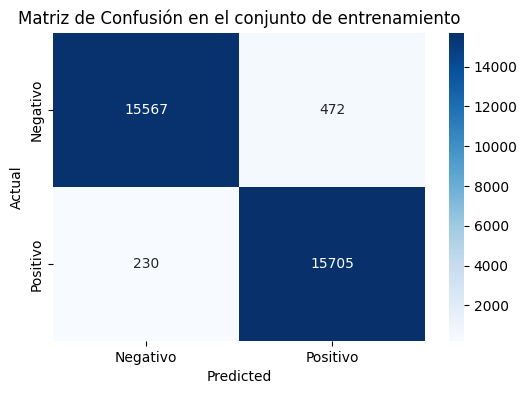

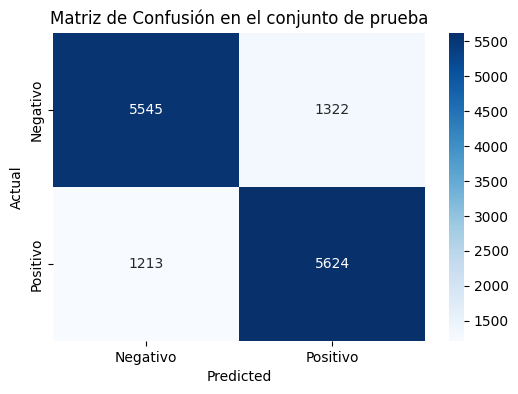

In [96]:
mostrar_matriz_confusion(best_xgboost, X_train, y_train, X_test, y_test)

Guardamos y cargamos el modelo

In [97]:
with open('modelo_xgboost.pkl', 'wb') as file:
    pickle.dump(best_xgboost, file)

with open('modelo_xgboost.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

Realizamos la predicción correspondiente, cambiando 0 y 1 por negativo y positivo

In [98]:
y_test_data_pred = loaded_model.predict(X_test_data)
y_test_data_pred = np.where(y_test_data_pred == 0, 'negativo', 'positivo')

Y conseguimos el dataframe, guardando el csv para realizar la predicción en Kaggle

In [99]:
predictions_df = pd.DataFrame({'ID': test_data['ID'], 'sentimiento': y_test_data_pred})
predictions_df.to_csv('predicciones_xgb_a.csv', index=False)